## Summarize a webpage to use an Open Source model running locally via Ollama rather than OpenAI

**Benefits:**

    1. No API charges - open-source
    2. Data doesn't leave your box

**Disadvantages:**

    1. Significantly less power than Frontier Models.


Installation of Ollama
Simply visit [ollama.com](https://ollama.com/) and install!

Once complete, the ollama server should already be running locally.
if you visit: http://localhost:11434/, You should see the message _**Ollama is running**_

If not, bring up a new Terminal (Mac) or Powershell (Windows) and enter **ollama serve**
And in another Terminal (Mac) or Powershell (Windows), enter *ollama pull llama3.2*
Then try *http://localhost:11434/* again.

If Ollama is slow on your machine, try using *llama3.2:1b* as an alternative. Run *ollama pull llama3.2:1b* from a Terminal or Powershell, and change the code below from *MODEL = "llama3.2"* to *MODEL = "llama3.2:1b"*

In [ ]:
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display

In [ ]:
# constants
OLLAMA_API = "http://localhost:11434/api/chat"
HEADERS = {"Content-Type": "application/json"}
MODEL = "llama3.2"

In [ ]:
# create a messages list using the same format like for OpenAI

messages = [
    {"role": "user", "content": "Describe some of the business applications of Generative AI"}
]

In [ ]:
payload = {
    "model": MODEL,
    "messages": messages,
    "stream": False
}

In [ ]:
# Let's just make sure the model is loaded

!ollama pull llama3.2

In [ ]:
# If this doesn't work for any reason, try the 2 versions in the following cells

response = requests.post(OLLAMA_API, json=payload, headers=HEADERS)
print(response.json()['message']['content'])

## Introducing the ollama package

Now we'lll do the same thing, but using the elegant ollama python package instead of direct HTTP call.

Under the hood, it's making the same call as above to the ollama server running at localhost:11434

In [ ]:
import ollama

response = ollama.chat(model = MODEL, messages = messages)
print(response['message']['content'])

## Alternative approach - using OpenAI python library to connect to Ollama

In [ ]:
# There's actually an alternative approach that some people might prefer
# You can use the OpenAI client python library to call Ollama:

from openai import OpenAI
ollama_via_openai = OpenAI(base_url = 'http://localhost:11434/v1', api_key='ollama')

response = ollama_via_openai.chat.completions.create(
    model = MODEL,
    messages = messages
)

print(response.choices[0].message.content)

## Are you confused about why that works ?

It seems strange, right? We just used OpenAI code to call Ollama?? What's going on?!

Here's the scoop:

The python class *OpenAI* is simply code written by OpenAI engineers that makes calls over the internet to an endpoint.

When you call *openai.chat.completions.create()*, this python code just makes a web request to the following url: "https://api.openai.com/v1/chat/completions"

Code like this is known as a "client library" - it's just wrapper code that runs on your machine to make web requests. The actual power of GPT is running on OpenAI's cloud behind this API, not on your computer!

OpenAI was so popular, that lots of other AI providers provided identical web endpoints, so you could use the same approach.

So Ollama has an endpoint running on your local box at http://localhost:11434/v1/chat/completions

And then the team at OpenAI had a great idea: they can extend their client library so you can specify a different 'base url', and use their library to call any compatible API.

That's it!

So when you say: *ollama_via_openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')*
Then this will make the same endpoint calls, but to Ollama instead of OpenAI.

## Also trying the amazing reasoning model DeepSeek

Here we use the version of DeepSeek-reasoner that's been distilled to 1.5B.
This is actually a 1.5B variant of Qwen that has been fine-tuned using synethic data generated by Deepseek R1.

Other sizes of DeepSeek are [here](https://ollama.com/library/deepseek-r1) all the way up to the full 671B parameter version, which would use up 404GB of your drive and is far too large for most!

In [ ]:
!ollama pull deepseek-r1:1.5b

In [ ]:
# This may take a few minutes to run! You should then see a fascinating "thinking" trace inside <think> tags, followed by some decent definitions

response = ollama_via_openai.chat.completions.create(
    model="deepseek-r1:1.5b",
    messages=[{"role": "user", "content": "Please give definitions of some core concepts behind LLMs: a neural network, attention and the transformer"}]
)

print(response.choices[0].message.content)

### Now let's get back to summarize the contents of a Webpage using llama

In [ ]:
# A class to represent a Webpage

# Some websites need you to use proper headers when fetching them:
headers = {
 "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"
}

class Website:

    def __init__(self, url):
        """
        Create this Website object from the given url using the BeautifulSoup library
        """
        self.url = url
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        self.title = soup.title.string if soup.title else "No title found"
        for irrelevant in soup.body(["script", "style", "img", "input"]):
            irrelevant.decompose()
        self.text = soup.body.get_text(separator="\n", strip=True)

In [ ]:
# Let's try one out. Change the website and add print statements to follow along.

ed = Website("https://edwarddonner.com")
print(ed.title)
print(ed.text)

### Types of prompts

You may know this already - but if not, you will get familiar with it.

Models like GPT4o have been trained to receive instructions in a particular way.

They expect to receive:

A **System prompt** that tells them what task they are performing and what tone they should use.

A **user prompt** the conversation starter that they should reply to

In [ ]:
# Define our system prompt - you can experiment with this later, changing the last sentence to 'Respond in markdown in Spanish."

system_prompt = "You are an assistant that analyzes the contents of a website \
and provides a short summary, ignoring text that might be navigation related. \
Respond in markdown."

In [ ]:
# A function that writes a User Prompt that asks for summaries of websites:

def user_prompt_for(website):
    user_prompt = f"You are looking at a website titled {website.title}"
    user_prompt += "\nThe contents of this website is as follows; \
please provide a short summary of this website in markdown. \
If it includes news or announcements, then summarize these too.\n\n"
    user_prompt += website.text
    return user_prompt

In [ ]:
print(user_prompt_for(ed))

In [ ]:
def messages_for(website):
    return [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt_for(website)}
    ]

In [ ]:
messages_for(ed)

In [ ]:
def summarize(url):
    website = Website(url)
    ollama_via_openai = OpenAI(base_url = 'http://localhost:11434/v1', api_key='ollama')
    response = ollama_via_openai.chat.completions.create(
        model = MODEL,
        messages = messages_for(website)
    )
    return response.choices[0].message.content
    

In [ ]:
summarize("https://edwarddonner.com")

In [ ]:
# A function to display this nicely in the Jupyter output, using markdonw

def display_summary(url):
    summary = summarize(url)
    display(Markdown(summary))

In [ ]:
display_summary("https://edwarddonner.com")

In [ ]:
import gradio as gr

def display_summary(url):
    summary = summarize(url)
    return summary 


# Create Gradio interface
iface = gr.Interface(
    fn=display_summary,         
    inputs=gr.Textbox(label="Enter URL"),  
    outputs=gr.Markdown(label="Summary"),  
    title="Webpage Summarizer",
    description="Enter a URL to generate a summary."
)


iface.launch()

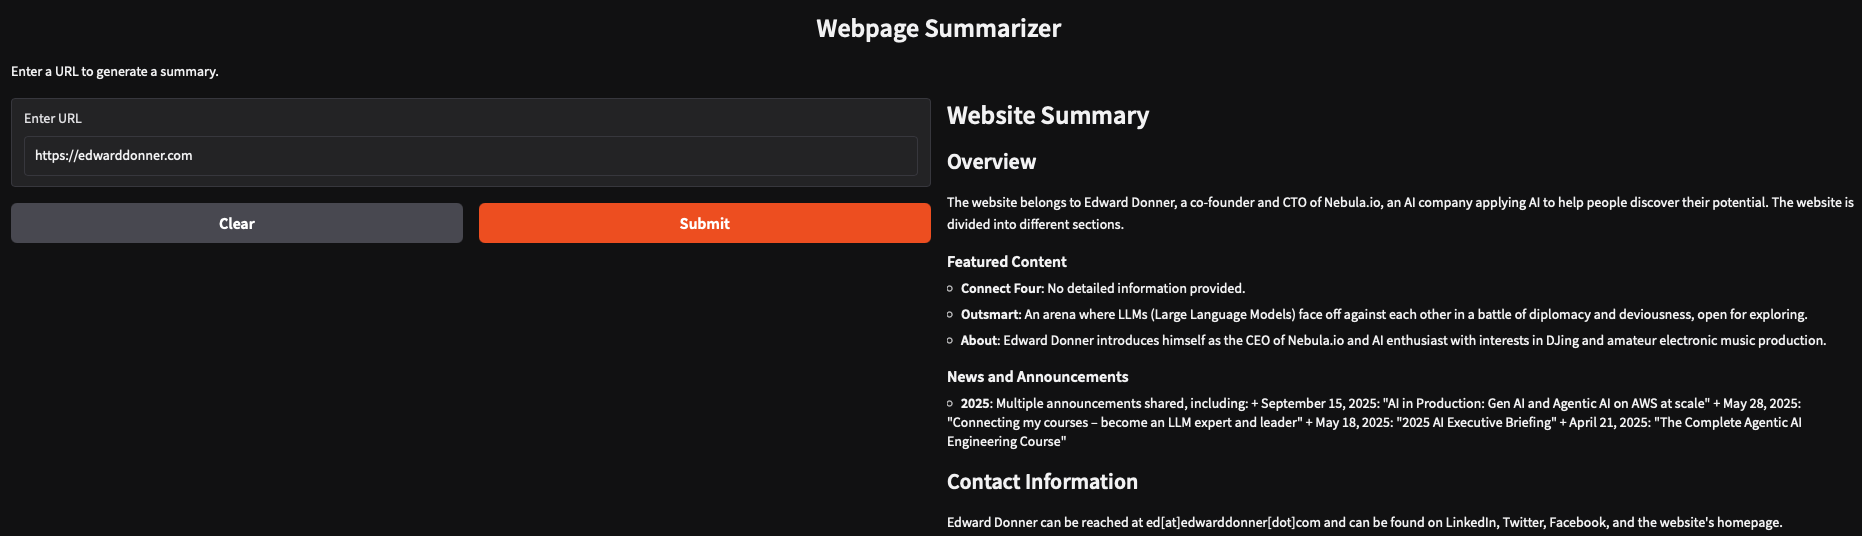